In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

# Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Only mutate binding sites

In [10]:
def sim_alt(promoter_seq, binding_site,
        func_pbound, binding_site_seqs, *args,
        num_mutants=10000,
        mutrate=0.1,
        allowed_alph=None,
        scaling_factor=100):
    
    bs_mutants = np.unique(tregs.wgregseq.mutations_rand(binding_site,
                                       rate=mutrate,
                                       num_mutants=num_mutants,
                                       allowed_alph=allowed_alph,
                                       number_fixed=True,
                                       keep_wildtype=True))
    left_bound, right_bound = tregs.seq_utils.find_binding_site(promoter, binding_site)
    left_region = promoter_seq[:left_bound]
    right_region = promoter_seq[right_bound:]
    mutants = [left_region + bs_mutant + right_region for bs_mutant in bs_mutants]
    print(mutants[:10])
    
    regions = []
    for bss in binding_site_seqs:
        start, end = tregs.seq_utils.find_binding_site(promoter_seq, bss)
        regions.append((start, end))

    df_sim = tregs.simulate.sim_helper(mutants, func_pbound, regions, *args)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_sim))
    df_sim['ct_0'] = dna_cnt
    df_sim = df_sim[df_sim.ct_0 != 0.0]

    df_sim['ct_1'] = 0.1 + df_sim['ct_0'] * df_sim['pbound'] * scaling_factor
    df_sim['ct_1'] = df_sim['ct_1'].astype(int)

    df_sim['ct_0'] = df_sim['ct_0'].astype(float)
    df_sim['ct_1'] = df_sim['ct_1'].astype(float)
    df_sim['norm_ct_1'] = df_sim['ct_1'] / df_sim['ct_0']

    return df_sim

In [12]:
n_NS = len(genome)
n_p = 4600
n_r = 15
ep_wt = -5
er_wt = -15

df = sim_alt(promoter, rnap_site, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
             *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
             mutrate=0.1)

['ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA', 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTcgGatGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA', 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTaGTagGtAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA', 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTacTcaGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA', 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATaTTGaGctGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA', 'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCAACGCAATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATaTatTtTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA', 'ACAGGTTTCCCGAC

/Users/rosalindpan/rpgroup/projects/theoretical_regseq/src/tregs/footprint.py:124: RuntimeWarning: divide by zero encountered in double_scalars
  mi += joint_p[1][i] * np.log2(joint_p[1][i] / (p_b[1] * p_mu[i]))


ValueError: Axis limits cannot be NaN or Inf

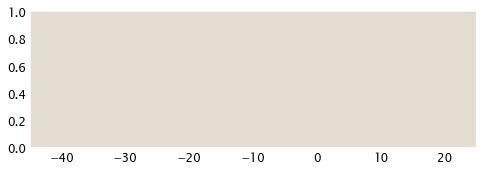

In [13]:
region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               x_lims=(-45, 25), fig_width=8,
                               legend_xcoord=1.35)